In [1]:
# Basic setup
import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions

In [2]:
# Reduce annoying TF messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Generate data from Bernoulli(0.6)
import numpy as np
xs = np.random.choice(2, p=[0.4, 0.6], size=100)

# Model description

We observe data $D = (x_t)_{t=1}^n$. We assume these come from some Bernoulli distribution with unknown parameter. We can write the model as follows:

$\theta \sim \textrm{Beta}(1,1)$

$x_t | \theta \sim \textrm{Bernoulli}(\theta)$

The next snippet describes the probabilistic model of $P(\theta, D)$, in particular, it links the two variables together.

In [4]:
# Gere we are setting up a model where
# theta ~ Beta(1,1)
# x_t | theta ~ Bernoulli(theta), with x_t, x_{t-1} independent.
jdn = tfd.JointDistributionNamed({
    'theta': tfd.Beta(concentration0=1, concentration1=1),
    'x_t': lambda theta : tfd.Independent(
        tfd.Bernoulli(probs=theta[...,tf.newaxis]),
        reinterpreted_batch_ndims=1
    )
})
# can't get reinterpreted_batch_ndims=1 to work

In [5]:
# Demonstration of sampling
jdn.sample(2) # take two samples

{'theta': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.4079306 , 0.26165068], dtype=float32)>,
 'x_t': <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [0]], dtype=int32)>}

In [6]:
# We can pick just one variable from the sample
jdn.sample(1)['x_t'] # take one sample, get only 'x_t'

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[0]], dtype=int32)>

# Estimation

First, we generate some data.
Then, we fix the values of some variables to be equal to the data values, and sample from the rest. 
It would have been nice if tfd allowed us to simply do tf.sample(x_t = data), but we must do something more complicated, which has the same effect.


Here we define:

$\ln \mathbb{P}_\xi(\theta, D) = \ln P_\theta(D) \xi(\theta) = \ln \prod_t P_\theta(x_t) \xi(\theta) = \sum_t \ln P_\theta(x_t) + \ln \xi(\theta)$,

or in alternative notation, where we just use $\Pr$ loosely,

$\Pr(\theta, D) = \Pr(D | \theta) \Pr(\theta) = \prod_t \Pr(x_t | \theta) \Pr(\theta)$.


In [7]:
# TFP makes no distinction between data and parameters.
# They are all just random variables.
# So we need to fix the value of the observed variables to equal the data values.
def target_log_prob(theta):
    return jdn.log_prob(theta=theta, x_t = xs)

In [8]:
target_log_prob(0.7) # this is the probability of X_s

<tf.Tensor: shape=(), dtype=float32, numpy=-68.712105>

# Maximum A Posteriori Estimate

$\arg\max_\theta \xi(\theta  | D) = \arg \max_\theta P_\theta(D) \xi(\theta) / \mathbb{P}_\xi(D) = \arg \max_\theta P_\theta(D) \xi(\theta)$



In [9]:
theta = tf.Variable(0.5)
loss = lambda: -target_log_prob(theta)
opt = tf.optimizers.SGD(learning_rate=0.001)  #note that this does not take into account constraints
loss_hist = []
var_hist = []
for _ in range(100):
    opt.minimize(loss, theta)
    loss_hist.append(loss().numpy())
    var_hist.append(theta.numpy())

0.61

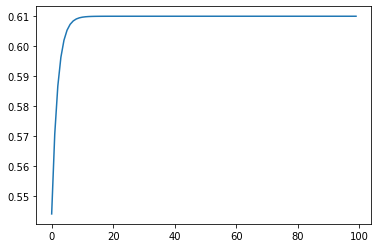

In [10]:
import matplotlib.pyplot as plt
plt.plot(var_hist)
np.mean(xs)

# Markov Chain Monte Carlo Estimation

We wish to estimate $\xi(\theta | D)$. We could do this if we could sample some values

$\theta_i \sim \xi(\theta | D)$.

Then we can use these samples as a proxy for the posterior distribution.


In [11]:
sampling_kernel = tfp.mcmc.RandomWalkMetropolis(target_log_prob)
#sampling_kernel = tfp.mcmc.HamiltonianMonteCarlo(
#    target_log_prob_fn = target_log_prob,
#    step_size=0.01,
#    num_leapfrog_steps=2
#)
    

In [12]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=sampling_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)
dtype=np.float32

In [13]:
initial_state = dtype(0.5)
samples, kernel_results = run_chain(initial_state, num_results=10000,num_burnin_steps=1000)

In [14]:
samples

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([0.61484504, 0.61484504, 0.61484504, ..., 0.5564077 , 0.5564077 ,
       0.5594913 ], dtype=float32)>

(array([ 111.,  182.,  805., 1915., 2257., 2207., 1427.,  652.,  343.,
         101.]),
 array([0.4752677 , 0.50206137, 0.52885497, 0.5556486 , 0.5824422 ,
        0.6092359 , 0.63602954, 0.66282314, 0.6896168 , 0.7164104 ,
        0.74320406], dtype=float32),
 <BarContainer object of 10 artists>)

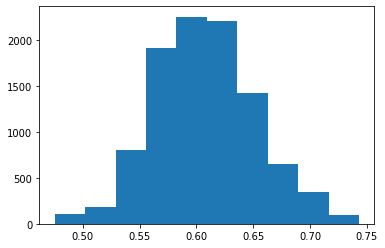

In [15]:
plt.hist(samples.numpy())